In [28]:
# imports
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sys

from dreem_tools import plotting, parse, dataframe

# general figure tweaks
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 20
# to fight the theme
plt.rcParams["figure.facecolor"] = "white"

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(BASE_DIR)

ANALYSIS_DIR = os.path.join(BASE_DIR, 'scripts', 'analysis')
sys.path.append(ANALYSIS_DIR)


In [3]:
df = pd.read_json("../data/wt_mg_titra.json")

## functions

In [41]:
def plot_pop_avg_traces_all(df, plot_sequence=False, ylim=None, **kwargs):
    fig, ax = plt.subplots(1, 1, **kwargs)
    for i, row in df.iterrows():
        if "label" in row:
            label = row["label"]
        else:
            label = row["rna_name"]
        plt.plot(row["data"], label=label, lw=4)
    #fig.legend(loc="upper left")
    if plot_sequence:
        seq = df.iloc[0]["sequence"]
        ss = df.iloc[0]["structure"]
        x = list(range(len(seq)))
        ax.set_xticks(x)
        ax.set_xticklabels([f"{s}\n{nt}" for s, nt in zip(seq, ss)])
    if ylim is not None:
        ax.set_ylim([0, ylim])
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(width=2)

    return fig

### buffer vs gaaa reactivity

In [55]:
df.columns

Index(['name', 'sequence', 'structure', 'data_type', 'num_reads', 'num_aligns',
       'data', 'no_mut', '1_mut', '2_mut', '3_mut', '3plus_mut', 'sn', 'dir',
       'rna_name', 'run_name', 'exp_name', 'code', 'length', 'barcode',
       'barcode_seq', 'buffer', 'buffer_conc', 'mg_conc', 'exp_type', 'gaaa',
       'gaaa_avg', 'tlr', 'ref_hp_1', 'ref_hp_1_avg', 'ref_hp_2',
       'ref_hp_2_avg', 'ires', 'kink_turn', '3x3_motif'],
      dtype='object')

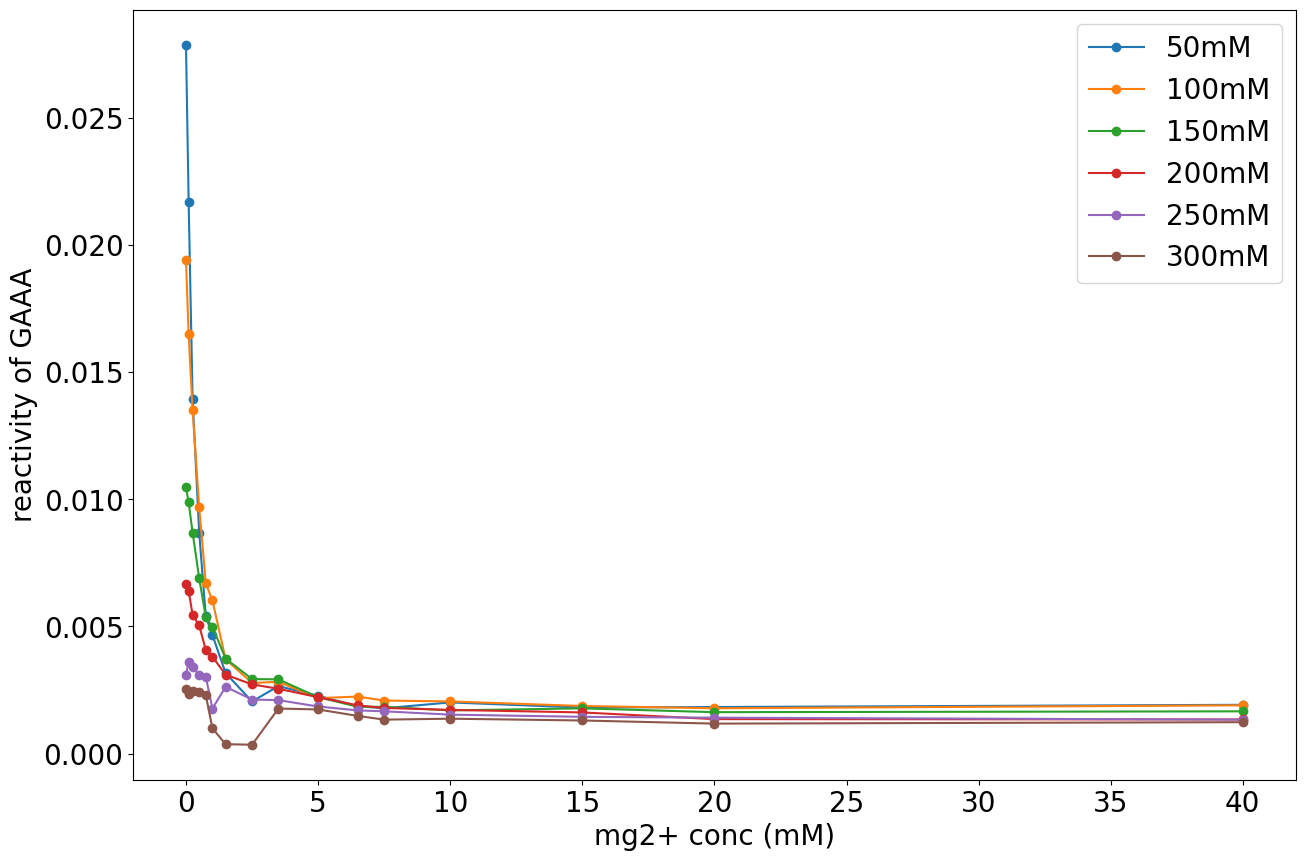

In [50]:
exp_names = [
    ["2022_07_27_C0117_50mM_NaC_Mg2+_titra_CM", "50mM"],
    ["2022_07_28_C0117_100mM_NaC_Mg_titra_CM", "100mM"],
    ["2022_07_29_C0117_150mM_NaC_Mg_titra_CM", "150mM"],
    ["2022_08_08_C0117_200mM_NaC_Mg_titra_CM", "200mM"],
    ["2022_08_09_C0117_250mM_NaC_Mg_titra_CM", "250mM"],
    ["2022_08_10_C0117_300mM_NaC_Mg_titra_CM", "300mM"],
]

for exp in exp_names:
    df_sub = df[df["exp_name"] == exp[0]]
    plt.plot(df_sub["mg_conc"], df_sub["gaaa_avg"], label=exp[1], marker="o", ms=10);
plt.ylabel("reactivity of GAAA")
plt.xlabel("mg2+ conc (mM)")
plt.legend()

In [72]:
data = [] 
count = 0
for exp in exp_names[::-1]:
    df_sub = df[df["exp_name"] == exp[0]]
    min_row = df_sub[df_sub["mg_conc"] == df_sub["mg_conc"].min()].iloc[0]
    max_row = df_sub[df_sub["mg_conc"] == df_sub["mg_conc"].max()].iloc[0]
    data.append([exp[1], count, min_row["gaaa_avg"], max_row["gaaa_avg"]])
    count += 1
df_sum = pd.DataFrame(data, columns=["mg_conc", "pos", "mg_0_react", "mg_40_react"])

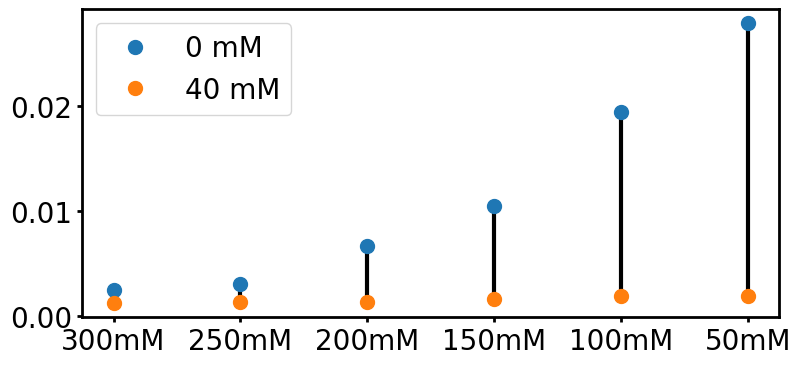

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
for i, row in df_sum.iterrows():
    plt.plot([row["pos"], row["pos"]], [row["mg_0_react"], row["mg_40_react"]], color="black", lw=3)
plt.plot(df_sum["pos"], df_sum["mg_0_react"], label="0 mM", marker="o", linestyle=None, lw=0, ms=10);
plt.plot(df_sum["pos"], df_sum["mg_40_react"], label="40 mM", marker="o", linestyle=None, lw=0, ms=10);
plt.xticks(df_sum["pos"], df_sum["mg_conc"])
plt.legend()
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.tick_params(width=2)


### comparision between 300 mM and 50 mM NaCoc with 10 mM Mg2+

In [91]:
row1 = df[(df.buffer == 'NaCoc') & (df.buffer_conc == 300)].iloc[0]
row2 = df[(df.buffer == 'NaCoc') & (df.buffer_conc == 50)].iloc[0]

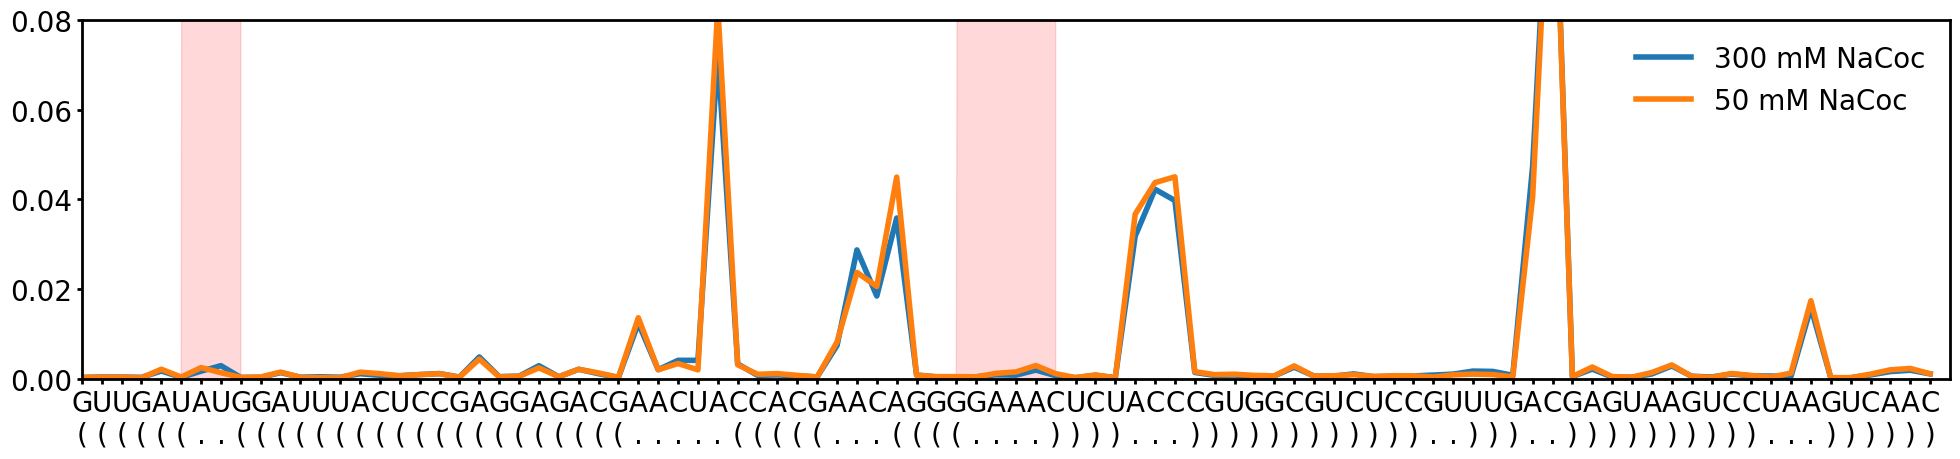

In [92]:
df_sub_1 = pd.DataFrame([row1, row2])
df_sub_1 = dataframe.trim(df_sub_1, 20, 22)
df_sub_1["label"] = ["300 mM NaCoc", "50 mM NaCoc"]
plot_pop_avg_traces_all(df_sub_1, plot_sequence=True, ylim=0.08, figsize=(20, 5));
plt.xlim([0, len(df_sub_1.iloc[0]["sequence"])])
plt.tight_layout()
plt.legend(loc='upper right', frameon=False)
x = range(0, len(df.iloc[0]["sequence"]))
plt.fill_between([5, 8], [0, 10], color='red', alpha=0.15, zorder=-1)
plt.fill_between([44, 49], [0, 10], color='red', alpha=0.15, zorder=-1)


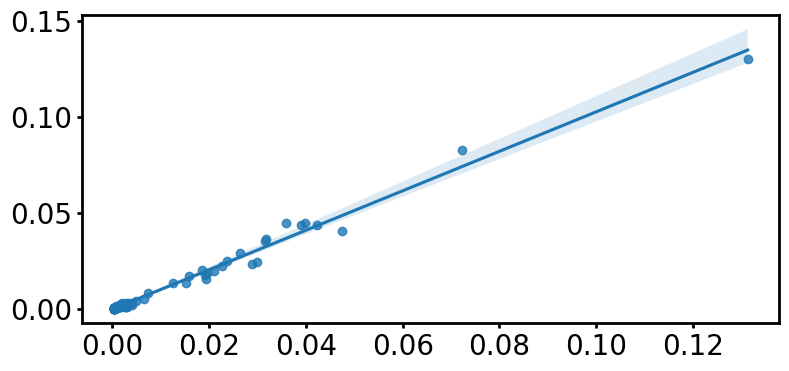

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
sns.regplot(row1['data'], row2['data'], ax=ax)
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.tick_params(width=2)

In [96]:
stats.pearsonr(row1['data'], row2['data'])[0] ** 2

0.9883131426027802

In [46]:
row1 = df[(df.buffer == 'NaCoc') & (df.mg_conc == 40) & (df.buffer_conc == 300)].iloc[0]
row2 = df[(df.buffer == 'NaCoc') & (df.mg_conc == 0) & (df.buffer_conc == 300)].iloc[0]

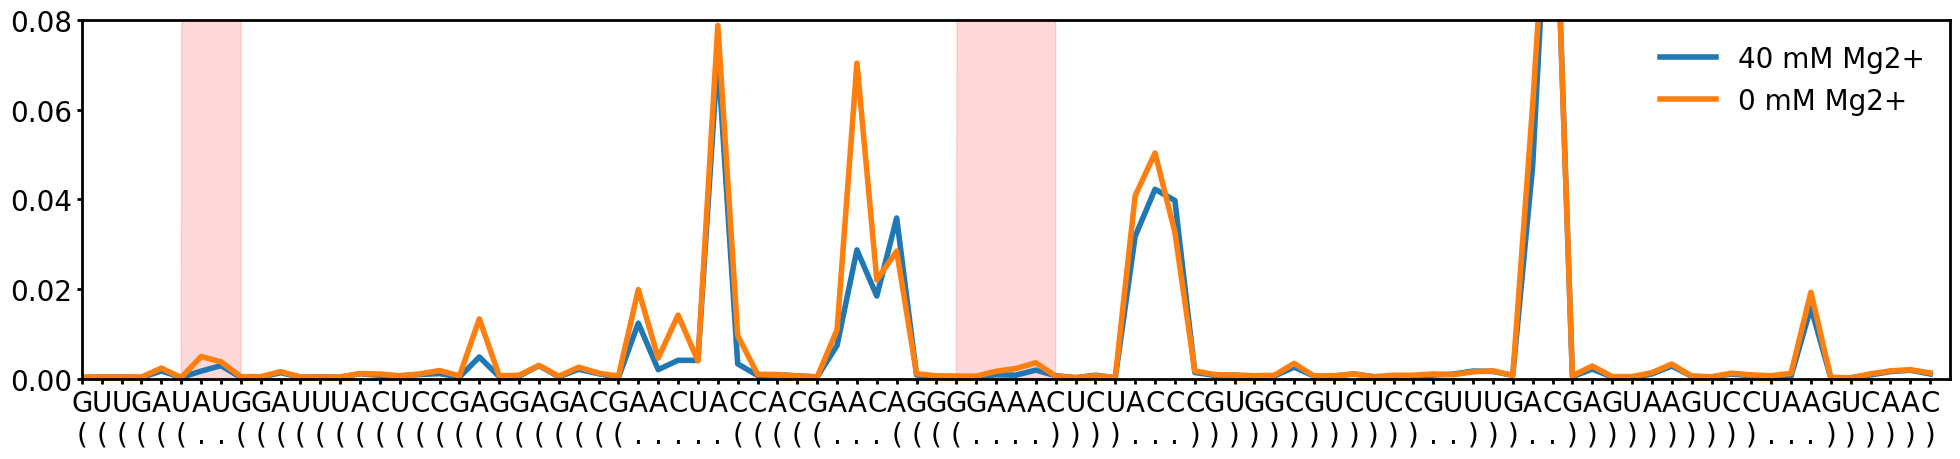

In [47]:
df_sub_1 = pd.DataFrame([row1, row2])
df_sub_1 = dataframe.trim(df_sub_1, 20, 22)
df_sub_1["label"] = ["40 mM Mg2+", "0 mM Mg2+"]
plot_pop_avg_traces_all(df_sub_1, plot_sequence=True, ylim=0.08, figsize=(20, 5));
plt.xlim([0, len(df_sub_1.iloc[0]["sequence"])])
plt.tight_layout()
plt.legend(loc='upper right', frameon=False)
x = range(0, len(df.iloc[0]["sequence"]))
plt.fill_between([5, 8], [0, 10], color='red', alpha=0.15, zorder=-1)
plt.fill_between([44, 49], [0, 10], color='red', alpha=0.15, zorder=-1)

In [48]:
row1 = df[(df.buffer == 'NaCoc') & (df.mg_conc == 40) & (df.buffer_conc == 50)].iloc[0]
row2 = df[(df.buffer == 'NaCoc') & (df.mg_conc == 0) & (df.buffer_conc == 50)].iloc[0]

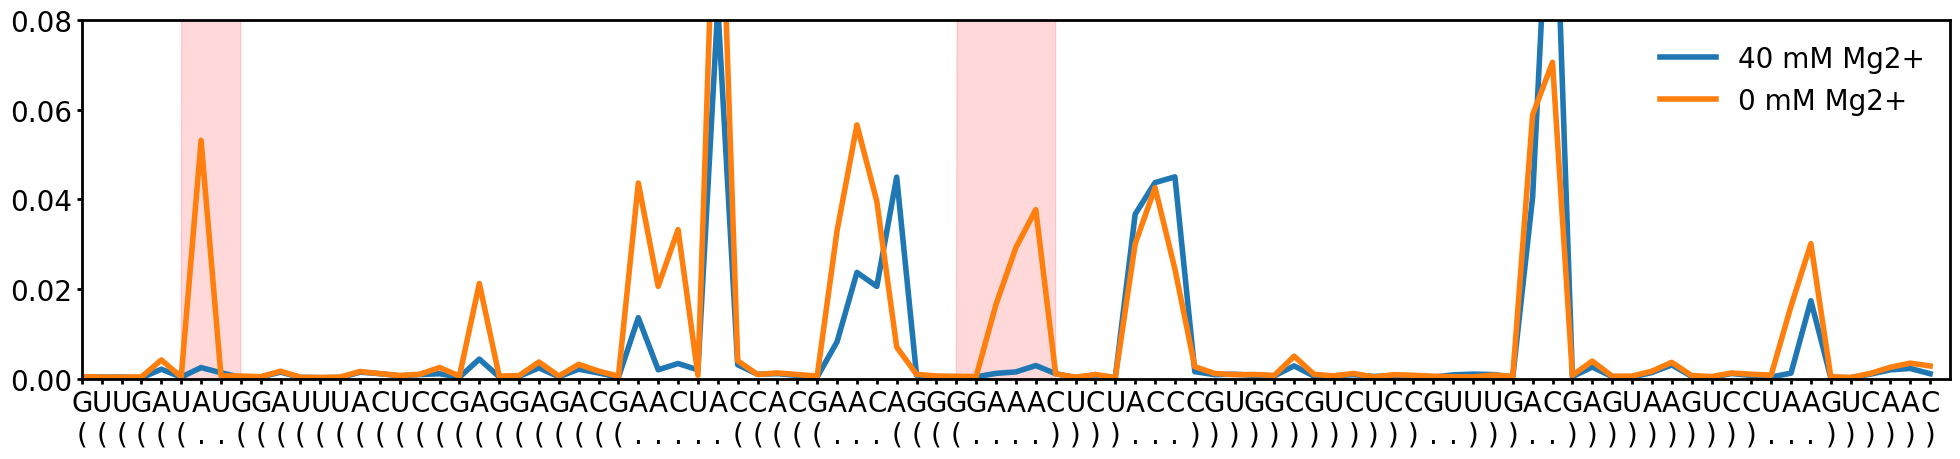

In [49]:
df_sub_1 = pd.DataFrame([row1, row2])
df_sub_1 = dataframe.trim(df_sub_1, 20, 22)
df_sub_1["label"] = ["40 mM Mg2+", "0 mM Mg2+"]
plot_pop_avg_traces_all(df_sub_1, plot_sequence=True, ylim=0.08, figsize=(20, 5));
plt.xlim([0, len(df_sub_1.iloc[0]["sequence"])])
plt.tight_layout()
plt.legend(loc='upper right', frameon=False)
x = range(0, len(df.iloc[0]["sequence"]))
plt.fill_between([5, 8], [0, 10], color='red', alpha=0.15, zorder=-1)
plt.fill_between([44, 49], [0, 10], color='red', alpha=0.15, zorder=-1)